<a href="https://colab.research.google.com/github/nicoeiris11/ResNet-DenseNet/blob/main/Tarea1TDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nicolás Eiris (182713) - Adrián Maximiliano Rial (174096)

### Tarea 1 - Taller de Deep Learning

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
! cp "/content/drive/My Drive/data/scene_classification.zip" .
! unzip -q scene_classification.zip
! rm scene_classification.zip

Mounted at /content/drive


In [ ]:
import time
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms.functional import pad
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Cargar dataset

In [ ]:
BATCH_SIZE = 32

In [ ]:
def get_dataloaders(train_transf, test_transf, batch_size):

  train_dataset = ImageFolder("train_set", transform=train_transf)
  test_dataset = ImageFolder("test_set", transform=test_transf)

  # Separamos en train y validation
  train_size = int(0.8 * len(train_dataset))
  valid_size = len(train_dataset) - train_size
  train, validation = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
  print(f"{len(train)} Training images, {len(validation)} Validation images, {len(test_dataset)} Test images")

  train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
  valid_loader = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)
  test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=4)


  return train_loader, valid_loader, test_loader

Train images count with different size (!= 150x150) : 48





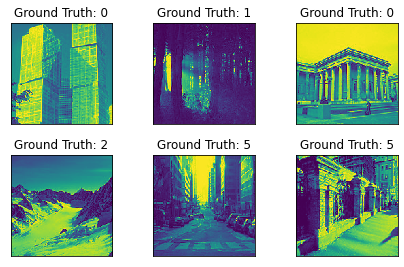

In [ ]:
transf = transforms.Compose([
    transforms.ToTensor()
])

def collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

train_dataset = ImageFolder("train_set", transform=transf)

example_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14034, collate_fn=collate, shuffle=True)

examples = enumerate(example_loader)
batch_idx, (example_data, example_targets) = next(examples)

different_sized_imgs = 0
for i in range(14034):
  if example_data[i].shape != (3, 150, 150):
    different_sized_imgs += 1

print("Train images count with different size (!= 150x150) : {}".format(different_sized_imgs))
print("\n\n")

# Image-Target Visualization
fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

### Padding para imagenes con dimension != 150x150

In [ ]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = 150
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return pad(image, padding, 0, 'constant')

## Funciones de entrenamiento y test

In [ ]:
def train_epoch(training_model, loader, criterion, optim):
    training_model.train()

    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    for images, labels in loader:
        all_labels.extend(labels.numpy())

        optim.zero_grad() 
   
        predictions = training_model(images.to(device))
        all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())

        loss = criterion(predictions, labels.to(device))
  
        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100

def validation_epoch(val_model, loader, criterion):
    val_model.eval()
    epoch_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
      for images, labels in loader:
          all_labels.extend(labels.numpy())
    
          predictions = val_model(images.to(device))
          all_predictions.extend(torch.argmax(predictions, dim=1).cpu().numpy())
    
          loss = criterion(predictions, labels.to(device))
    
          epoch_loss += loss.item()
    return epoch_loss / len(loader), accuracy_score(all_labels, all_predictions) * 100, precision_score(all_labels, all_predictions, average="weighted") * 100, recall_score(all_labels, all_predictions, average="weighted") * 100 , f1_score(all_labels, all_predictions, average="weighted") * 100


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optim, number_epochs):
  train_history = []
  test_history = []

  for epoch in range(number_epochs):
      start_time = time.time()

      train_loss, train_acc, _, _, _ = train_epoch(model, train_loader, criterion, optimizer)
      train_history.append(train_loss)
      print("Training epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, train_loss, train_acc, time.time() - start_time))

      start_time = time.time()
      test_loss, acc, prec, recall, f1 = validation_epoch(model, test_loader, criterion)
      test_history.append(test_loss)
      print("Validation epoch {} | Loss {:.6f} | Accuracy {:.2f}% | Time {:.2f} seconds"
            .format(epoch + 1, test_loss, acc, time.time() - start_time))
      
  return train_history, test_history

## Definición del modelo

### Modelo 1 - Custom CNN

In [ ]:
class CustomCNN(nn.Module):
  def __init__(self, in_channels):
    # in_channels: int, cantidad de canales de la imagen original
    super(CustomCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3,stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3,stride = 1, padding = 1)
    self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride = 1, padding = 1)
    self.dropout = nn.Dropout(0.5)
    self.fully_connected = nn.Linear(in_features=18 * 18 * 128, out_features=512)
    self.output = nn.Linear(in_features = 512, out_features=6)

  def forward(self, x):
    result = F.relu(self.conv1(x))
    result = F.relu(self.conv2(result))
    result = self.pooling(result)
    result = F.relu(self.conv3(result))
    result = F.relu(self.conv4(result))
    result = self.pooling(result)
    result = F.relu(self.conv5(result))
    result = self.pooling(result)
    result = result.flatten(1)
    result = self.dropout(result)
    result = F.relu(self.fully_connected(result))
    result = self.dropout(result)
    result = self.output(result)
    return result

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 30

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.RandomCrop(150, pad_if_needed=True),
    transforms.Resize((144, 144)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomCrop(150, pad_if_needed=True),
    transforms.Resize((144, 144)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

custom_cnn_net = CustomCNN(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(custom_cnn_net.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(custom_cnn_net, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images, 3000 Test images
Training epoch 1 | Loss 1.273552 | Accuracy 49.87% | Time 27.33 seconds
Validation epoch 1 | Loss 1.014009 | Accuracy 59.46% | Time 4.26 seconds
Training epoch 2 | Loss 1.015991 | Accuracy 60.52% | Time 27.75 seconds
Validation epoch 2 | Loss 0.901340 | Accuracy 63.77% | Time 4.27 seconds
Training epoch 3 | Loss 0.921563 | Accuracy 64.60% | Time 28.11 seconds
Validation epoch 3 | Loss 0.822515 | Accuracy 68.44% | Time 4.31 seconds
Training epoch 4 | Loss 0.838983 | Accuracy 68.08% | Time 28.15 seconds
Validation epoch 4 | Loss 0.769442 | Accuracy 70.04% | Time 4.29 seconds
Training epoch 5 | Loss 0.805769 | Accuracy 69.82% | Time 28.21 seconds
Validation epoch 5 | Loss 0.790452 | Accuracy 67.76% | Time 4.29 seconds
Training epoch 6 | Loss 0.757067 | Accuracy 71.60% | Time 28.34 seconds
Validation epoch 6 | Loss 0.701661 | Accuracy 73.32% | Time 4.36 seconds
Training epoch 7 | Loss 0.720094 | Accuracy 73.15% | Time 28.40 se

Custom CNN Test set: 0.467559 Loss. Accuracy 84.43%. Precision 84.59%. Recall 84.43%. F1 84.43%


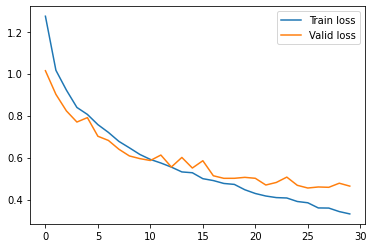

In [ ]:
test_loss, accuracy, prec, recall, f1 = validation_epoch(custom_cnn_net, test_loader, criterion)
print(f"Custom CNN Test set: {test_loss:.6f} Loss. Accuracy {accuracy:.2f}%. Precision {prec:.2f}%. Recall {recall:.2f}%. F1 {f1:.2f}%")

plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

### Modelo 2 - DenseNet

In [ ]:
class DenseBlock(nn.Module):
  def __init__(self, in_channels):
    super(DenseBlock, self).__init__()
    self.bn = nn.BatchNorm2d(num_features=in_channels)
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3,stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=3, stride = 1, padding = 1)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, stride = 1, padding = 1)
    # es 128 ya que usa la suma de las convoluciones 32 + 32 + 32 + 32 + 32

  def forward(self, x):
    normalized = self.bn(x)

    conv1 = F.relu(self.conv1(normalized))
    
    conv2 = F.relu(self.conv2(conv1))
    c2_dense = torch.cat([conv1,conv2], 1)
    
    conv3 = F.relu(self.conv3(c2_dense))
    c3_dense = torch.cat([conv1, conv2, conv3], 1)
    
    conv4 = F.relu(self.conv4(c3_dense))
    c4_dense = torch.cat([conv1, conv2, conv3, conv4], 1)
    
    conv5 = F.relu(self.conv5(c4_dense))
    c5_dense = torch.cat([conv1, conv2, conv3, conv4, conv5], 1)
    
    return c5_dense

In [ ]:
class TransitionLayer(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(TransitionLayer, self).__init__()
    self.bn = nn.BatchNorm2d(num_features = in_channels)
    self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1)
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)
  
  def forward(self, x):
    normalized = self.bn(x)
    out = F.relu(self.conv(normalized))
    out = self.avgpool(out)
    return out

In [ ]:
class DenseNet(nn.Module):
    def __init__(self, n_classes):
        super(DenseNet, self).__init__()
    
        self.input_convolution = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
    
        self.dense1 = DenseBlock(in_channels = 64)
        self.dense2 = DenseBlock(in_channels = 128)
        self.dense3 = DenseBlock(in_channels = 128)

      # El 160 sale del primer bloque denso que era 128 + 32
        self.transition1 = TransitionLayer(in_channels= 160, out_channels = 128)
        self.transition2 = TransitionLayer(in_channels= 160, out_channels = 128)
        self.transition3 = TransitionLayer(in_channels= 160, out_channels = 64)
        
        self.fully_connected = nn.Linear(in_features = 64 * 18 * 18, out_features = 512)
        self.output = nn.Linear(512, n_classes)

    def forward(self, x):
        out = F.relu(self.input_convolution(x))
    
        out = self.dense1(out)
        out = self.transition1(out)
    
        out = self.dense2(out)
        out = self.transition2(out)
    
        out = self.dense3(out)
        out = self.transition3(out)
    
        out = out.flatten(1)
    
        out = F.relu(self.fully_connected(out))
        out = self.output(out)
    
        return out

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 10

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.Resize((144, 144)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomCrop(150, pad_if_needed=True),
    transforms.Resize((144, 144)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

dense_net_model = DenseNet(6).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(dense_net_model.parameters(), lr=LR, weight_decay=0.0001)

train_loss, valid_loss = train_model(dense_net_model, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images, 3000 Test images
Training epoch 1 | Loss 0.858346 | Accuracy 66.97% | Time 154.51 seconds
Validation epoch 1 | Loss 0.675575 | Accuracy 76.10% | Time 10.34 seconds
Training epoch 2 | Loss 0.575360 | Accuracy 78.93% | Time 159.22 seconds
Validation epoch 2 | Loss 0.530105 | Accuracy 80.83% | Time 10.47 seconds
Training epoch 3 | Loss 0.504101 | Accuracy 81.95% | Time 159.42 seconds
Validation epoch 3 | Loss 0.514323 | Accuracy 81.33% | Time 10.39 seconds
Training epoch 4 | Loss 0.432484 | Accuracy 84.35% | Time 159.31 seconds
Validation epoch 4 | Loss 0.494024 | Accuracy 82.37% | Time 10.43 seconds
Training epoch 5 | Loss 0.399137 | Accuracy 85.25% | Time 159.14 seconds
Validation epoch 5 | Loss 0.417330 | Accuracy 84.93% | Time 10.36 seconds
Training epoch 6 | Loss 0.351074 | Accuracy 87.34% | Time 158.96 seconds
Validation epoch 6 | Loss 0.414835 | Accuracy 85.07% | Time 10.44 seconds
Training epoch 7 | Loss 0.328042 | Accuracy 87.96% | T

Custom CNN Test set: 0.377760 Loss. Accuracy 88.07%. Precision 88.27%. Recall 88.07%. F1 88.05%


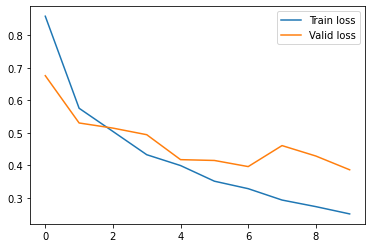

In [ ]:
test_loss, accuracy, prec, recall, f1 = validation_epoch(dense_net_model, test_loader, criterion)
print(f"Custom CNN Test set: {test_loss:.6f} Loss. Accuracy {accuracy:.2f}%. Precision {prec:.2f}%. Recall {recall:.2f}%. F1 {f1:.2f}%")

plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

### Modelo 3 - RESNET 18

In [ ]:
class ResNet18(nn.Module):
  def __init__(self, in_channels):
    super(ResNet18, self).__init__()

    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 7, padding = 3)
    self.group1 = ResGroup(channels = 64, should_halve = False)
    self.group2 = ResGroup(channels = 128, should_halve = True)
    self.group3 = ResGroup(channels = 256, should_halve = True)
    self.group4 = ResGroup(channels = 512, should_halve = True)

    self.bn = nn.BatchNorm2d(num_features = 64)
    self.max_pool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.dropout = nn.Dropout(0.5)
    
    self.linear1 = nn.Linear(in_features = 512 * 1 * 1, out_features = 128)
    self.output = nn.Linear(in_features = 128, out_features = 6)

  def forward(self, x):
    out = F.relu(self.bn(self.conv1(x)))
    out = self.max_pool(out)

    out = self.group1(out)

    out = self.group2(out)

    out = self.group3(out)

    out = self.group4(out)

    out = self.avgpool(out)
    
    out = out.flatten(1)

    out = self.dropout(out)

    out = F.relu(self.linear1(out))

    return self.output(out)

In [ ]:
class ResGroup(nn.Module):
  def __init__(self, channels, should_halve):
    super(ResGroup, self).__init__()
    self.resBlock1 = ResBlock(channels, should_halve)
    self.resBlock2 = ResBlock(channels, False)
  
  def forward(self, x):
    out = self.resBlock1(x)
    out = self.resBlock2(out)
    return out

In [ ]:
class ResBlock(nn.Module):
  def __init__(self, channels, should_halve):
    super(ResBlock, self).__init__()
    self.should_halve = should_halve
    if should_halve:    
      self.conv1 = nn.Conv2d(in_channels = int(channels / 2), out_channels = channels, kernel_size = 3, stride = 2, padding = 1)
    else:
      self.conv1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
    
    self.conv2 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(num_features = channels)
    self.bn2 = nn.BatchNorm2d(num_features = channels)
    self.bn3 = nn.BatchNorm2d(num_features = channels)

    if should_halve:
      self.conv1x1 = nn.Conv2d(in_channels = int(channels / 2), out_channels = channels, stride = 2, kernel_size = 1)
  
  def forward(self, x):
    inputs = x
    conv1 = F.relu(self.bn1(self.conv1(x)))
    conv2 = self.bn2(self.conv2(conv1))
    if self.should_halve:
      inputs = self.conv1x1(inputs)
      inputs = self.bn3(inputs)
    return F.relu(conv2 + inputs)

#### Sin transforms

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 30

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

res_net_model = ResNet18(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(res_net_model.parameters(), lr=LR, weight_decay = 0.0001)

train_loss, valid_loss = train_model(res_net_model, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images, 3000 Test images
Training epoch 1 | Loss 0.857537 | Accuracy 67.13% | Time 83.30 seconds
Validation epoch 1 | Loss 0.731401 | Accuracy 72.32% | Time 6.63 seconds
Training epoch 2 | Loss 0.595920 | Accuracy 78.44% | Time 85.88 seconds
Validation epoch 2 | Loss 0.764309 | Accuracy 73.35% | Time 6.74 seconds
Training epoch 3 | Loss 0.504908 | Accuracy 81.94% | Time 86.80 seconds
Validation epoch 3 | Loss 0.610223 | Accuracy 75.95% | Time 6.76 seconds
Training epoch 4 | Loss 0.445702 | Accuracy 84.06% | Time 86.84 seconds
Validation epoch 4 | Loss 0.585436 | Accuracy 79.41% | Time 6.75 seconds
Training epoch 5 | Loss 0.405062 | Accuracy 85.72% | Time 86.75 seconds
Validation epoch 5 | Loss 0.454622 | Accuracy 84.18% | Time 6.79 seconds
Training epoch 6 | Loss 0.364467 | Accuracy 87.10% | Time 86.84 seconds
Validation epoch 6 | Loss 0.517401 | Accuracy 80.90% | Time 6.78 seconds
Training epoch 7 | Loss 0.346328 | Accuracy 87.66% | Time 86.83 se

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training epoch 15 | Loss 0.133359 | Accuracy 95.34% | Time 86.85 seconds
Validation epoch 15 | Loss 0.945538 | Accuracy 75.35% | Time 6.75 seconds
Training epoch 16 | Loss 0.116058 | Accuracy 96.00% | Time 86.72 seconds
Validation epoch 16 | Loss 0.569009 | Accuracy 83.90% | Time 6.79 seconds
Training epoch 17 | Loss 0.107818 | Accuracy 96.54% | Time 86.79 seconds
Validation epoch 17 | Loss 0.459504 | Accuracy 87.00% | Time 6.74 seconds
Training epoch 18 | Loss 0.080991 | Accuracy 97.42% | Time 86.81 seconds
Validation epoch 18 | Loss 0.491912 | Accuracy 86.96% | Time 6.72 seconds
Training epoch 19 | Loss 0.091195 | Accuracy 96.83% | Time 86.63 seconds
Validation epoch 19 | Loss 0.522857 | Accuracy 85.46% | Time 6.77 seconds
Training epoch 20 | Loss 0.071713 | Accuracy 97.70% | Time 86.78 seconds
Validation epoch 20 | Loss 0.669421 | Accuracy 84.68% | Time 6.78 seconds
Training epoch 21 | Loss 0.068773 | Accuracy 97.77% | Time 86.68 seconds
Validation epoch 21 | Loss 0.581465 | Accurac

ResNet Test set: 0.917856 Loss. Accuracy 77.80%. Precision 80.83%. Recall 77.80%. F1 77.53%


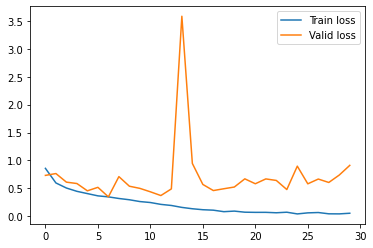

In [ ]:
test_loss, accuracy, prec, recall, f1 = validation_epoch(res_net_model, test_loader, criterion)
print(f"ResNet Test set: {test_loss:.6f} Loss. Accuracy {accuracy:.2f}%. Precision {prec:.2f}%. Recall {recall:.2f}%. F1 {f1:.2f}%")

plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

#### Con Transforms

In [ ]:
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

LR = 0.0001
NUMBER_EPOCHS = 30

# Creamos los datasets
test_transform = transforms.Compose([
    transforms.RandomCrop(150, pad_if_needed=True),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.RandomCrop(150, pad_if_needed=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing()
])

train_loader, valid_loader, test_loader = get_dataloaders(train_transform, test_transform, BATCH_SIZE)

res_net_model_aug = ResNet18(3).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(res_net_model_aug.parameters(), lr=LR, weight_decay = 0.0001)

train_loss, valid_loss = train_model(res_net_model_aug, train_loader, valid_loader, criterion, optimizer, NUMBER_EPOCHS)

11227 Training images, 2807 Validation images, 3000 Test images
Training epoch 1 | Loss 0.893966 | Accuracy 65.62% | Time 83.30 seconds
Validation epoch 1 | Loss 0.814638 | Accuracy 69.75% | Time 6.64 seconds
Training epoch 2 | Loss 0.631770 | Accuracy 76.95% | Time 85.79 seconds
Validation epoch 2 | Loss 1.024397 | Accuracy 70.54% | Time 6.77 seconds
Training epoch 3 | Loss 0.536225 | Accuracy 80.76% | Time 86.54 seconds
Validation epoch 3 | Loss 0.862293 | Accuracy 68.22% | Time 6.79 seconds
Training epoch 4 | Loss 0.493490 | Accuracy 82.18% | Time 86.73 seconds
Validation epoch 4 | Loss 0.490351 | Accuracy 82.51% | Time 6.81 seconds
Training epoch 5 | Loss 0.442407 | Accuracy 84.03% | Time 86.90 seconds
Validation epoch 5 | Loss 0.426382 | Accuracy 84.72% | Time 6.80 seconds
Training epoch 6 | Loss 0.413261 | Accuracy 85.49% | Time 86.78 seconds
Validation epoch 6 | Loss 0.402634 | Accuracy 86.25% | Time 6.80 seconds
Training epoch 7 | Loss 0.399266 | Accuracy 86.01% | Time 86.78 se

Custom CNN Test set: 0.366716 Loss. Accuracy 88.97%. Precision 89.06%. Recall 88.97%. F1 88.98%


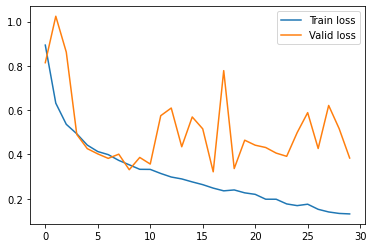

In [ ]:
test_loss, accuracy, prec, recall, f1 = validation_epoch(res_net_model_aug, test_loader, criterion)
print(f"Custom CNN Test set: {test_loss:.6f} Loss. Accuracy {accuracy:.2f}%. Precision {prec:.2f}%. Recall {recall:.2f}%. F1 {f1:.2f}%")

plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

# Conclusiones

### Pre-procesamiento de imágenes

#### Análisis del dataset

Previo a implementar la solución tomamos la decisión de analizar las imágenes del dataset tanto de train como de test. Esto fue de gran ayuda para conocer la dimensión de la gran mayoría de las imágenes (150x150), así como también de aquellas que no cumplen con la dimensión mencionada. En train identificamos **48** y en test **7** con dimension distinta a 150x150. Vale aclarar para toda imágen con distinta dimensión a 150x150, tanto la altura como el ancho es <= 150.

#### Decisiones post-análisis

En una primera instancia agregamos "Resize(150, 150)"
a los transforms parametrizados en los DataLoaders, para que los batches tuvieran imágenes de mismo tamaño. Esto no funcionó para nuestro modelo inicial (CustomCNN) ya que contaba con capas de pooling, y al achicar los tamaños necesitabamos que la dimensión resultante fuese un número entero.

Por tanto, lo que hicimos fue modificar la transformación de Resize: "Resize(144, 144)".
Aunque somos conscientes que achicar la imágen implica pérdida de información, consideramos que 6 pixeles en 150 no es tan significativo y esto nos permitiría evaluar nuestro modelo rápidamente.

Finalizadas las primeras iteraciones sobre la tarea, tomamos la decisión  de implementar un mecanismo de padding con el objetivo de rellenar con 0s aquellas imágenes que no cumplan con la dimensión 150x150.

Para esto utilizamos 2 formas. Primero utilizamos una implementación custom para generar el padding a mano "SquarePad()" y luego vimos que había un Transform de torchVision, RandomCrop, que si le pasas un tamaño resultante de imagen más grande le hace el padding a la imagen. Al utilizar este último nuestros modelos funcionaron mejor, entonces dejamos dicha implementación.

#### Transformaciones

- VerticalFlip: si bien lo probamos no lo terminamos usando, ya que la densidad de imágenes de paisajes es muy alta en el dataset. Por lo tanto no creemos que aprender a identificar paisajes dados vuelta (verticalmente) sea muy favorable para nuestra realidad.

- HorizontalFlip: en este caso si le encontramos sentido a rotar imágenes con eje vertical, ya que en los paisajes los elementos como ser cielo, montañas, entre otros, se repiten mucho en el dataset y de esta forma se aprende a generalizar la identificación de features de manera más eficaz.

- RandomErasing: Vimos que habian varias imagenes de personas con paisajes de fondo, entonces consideramos que usar RandomErasing, que elimina una parte de la foto podía ayudar a que la red ignore en ciertos casos la presencia de elementos que no se quieren identificar.

- RandomCrop: Como mencionamos anteriormente, al analizar los datos vimos que algunas imágenes no contaban con la dimension 150x150, por lo tanto utilizamos RandomCrop con dimensión 150 y padding con el objetivo de agregar padding a aquellas imágenes que no cuentan con la dimensión estándar (vale aclarar que no lo utilizamos para hacer zoom a las imágenes).


### Arquitectura

Al momento de definir la arquitectura de nuestro modelo, vimos que arquitecturas como la de LeNet eran muy poco complejas para resolver el problema.

Por lo tanto, decidimos comenzar probando con una arquitectura más profunda definida por nosotros. La misma contaba con 5 capas convolucionales y una capa lineal oculta, y utilizamos max pooling para hacer downsampling. Con esto obtuvimos una performance relativamente buena (entre 70 y 80%), pero un gran sobreajuste (por encima del 90% de *accuracy* en train, incluso llegando a valores cercanos al 96%).

Para atacar el problema de sobreajuste usamos distintas técnicas de regularización. A modo de ejemplo, agregamos dropout a las capas lineales del final, probamos distintos valores de weight_decay en el optimizador y también utilizamos Image Augmentation. De esta forma logramos bajar notoriamente el sobreajuste y conseguimos un modelo con resultados similares en train, validación y test con una *accuracy* de **84.43%**. Es decir, un modelo con un mayor poder de generalización.

Siendo conscientes que apuntar a tener redes demasiado profundas puede llevar a problemas como *vanishing gradients*, decidimos probar con arquitecturas que utilicen *skip connections*. En particular, implementamos DenseNet y ResNet18, adaptándolas a nuestro problema en particular.

Como primer acercamiento a una red profunda, decidimos utilizar DenseNet, la cual se había visto en el práctico para el dataset de CIFAR10 con muy buenos resultados. La única modificación que le realizamos se basó en el tamaño de las imagenes (específicamente el tamaño de las capas lineales luego del *flatten*), así como la cantidad de clases a retornar.

Los resultados fueron buenos, lo cual nos motivó a seguir en la búsqueda de una arquitectura compleja que nos permitiera obtener resultados por encima del 85% de *accuracy*.

Por esta razón decidimos realizar nuestra propia implementación de ResNet18. Construímos la misma siguiendo el artículo en el que fue presentada. Tuvimos que hacer adaptaciones para este problema en particular, como por ejemplo el output, que en este caso debía devolver 6 clases posibles. A su vez, en pruebas posteriores modificamos la última capa oculta lineal por una que nos funcionaba mejor y agregamos Dropout. Con estos cambios se logró mejorar los resultados para este problema en particular.

No teniamos certeza si nuestra implementación de ResNet18 era correcta, por lo que decidimos utilizar la implementación de torchvision con el objetivo de comparar los resultados con nuestra implementación. Esto nos permitió confirmar que los resultados eran muy similares. También evaluamos la opción de implementar ResNet34, pero al probar la versión de torchvision no vimos mejoría sustancial, por lo cual decidimos continuar probando distintas parametrizaciones de nuestra implementación de ResNet18.


### Entrenamiento

Al momento de entrenar siempre utilizamos un conjunto de datos de entrenamiento y uno de validación. Esto nos permitió en cada epoch poder ver la performance en datos no vistos.

A su vez, como función de costo utilizamos CrossEntropy, la cual es adecuada para problemas de clasificación.

En cuanto a los optimizadores, probamos SGD y Adam, siendo este último con el que conseguimos mejores resultados y por ende con el que decidimos realizar la mayoría de nuestras pruebas. Al utilizar los optimizadores probamos con varios valores de learning rate y de weight decay. A modo de ejemplo, con Adam los valores de learning rate que mejor nos funcionaron fueron 0.001 y 0.0001.

Otro de las variables con la que hicimos varias pruebas fue con el tamaño de los batch. Probamos con batchs de 32, 64, 128 y 256 para todas las arquitecturas, obteniendo los resultados más interesantes con batchs de tamaño 32.

Al comenzar modificaciones al modelo, inicialmente probamos con 10 epochs. En caso que notaramos que la pérdida en validación y la accuracy aun tenían tendencia a seguir disminuyendo o queriamos ver como funcionaba con más epochs, se aumentaba la cantidad de los mismos. 

Otro aspecto más a destacar es que al probar nuestro modelo primero probamos sin realizar transformaciones de Image Augmentation y luego buscamos mejorarlo utilizando las transformaciones que consideramos adecuadas.

A la hora de implementar los modelos fue de suma utilidad graficar la evolución de la loss tanto en train como en validación con el objetivo de obtener indicios (como por ejemplo sobreajuste) de como ir modificando los hiperparametros del modelo.

A continuación mostramos la gráfica para CustomCNN donde podemos ver que a partir de la epoch ~#18 se entra en una zona donde la curva de train y de validación se distancian dando la pauta de un posible sobreajuste en próximas iteraciones.

Teniendo esto en cuenta, si el proyecto asociado a esta Tarea continuara en el tiempo, se podría experimentar la implementación de Early Stopping con el fin de regularizar el modelo.

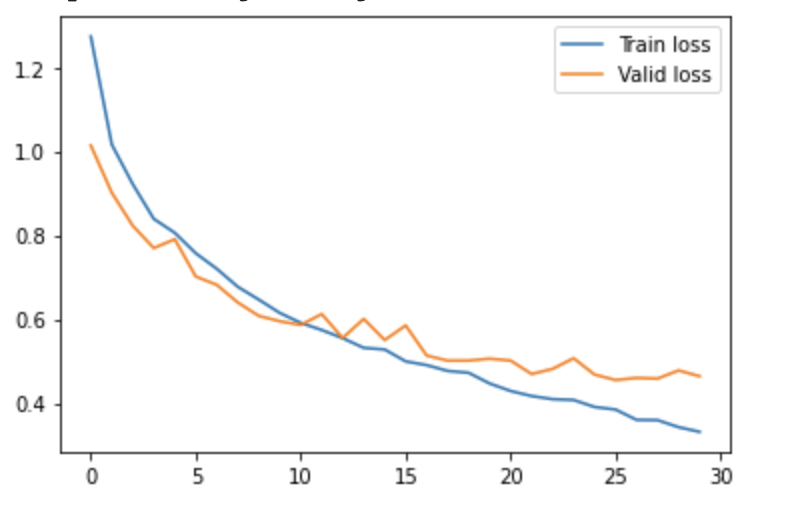


#### Tabla comparativa de modelos

A continuación se muestra una tabla comparando los modelos y las métricas solicitadas como parte de la entrega.

Podemos notar como CustomCNN es la que tiene peor performance y esto se debe a que no cuenta con tanta profundidad (complejidad) como DenseNet y ResNet-18.
Esto tiene sentido ya que tanto DenseNet como ResNet surgen a partir de amplias investigaciones. Sus resultados se encuentran respaldados por comparaciones exhaustivas y largas pruebas con variaciones de hiperparametros.

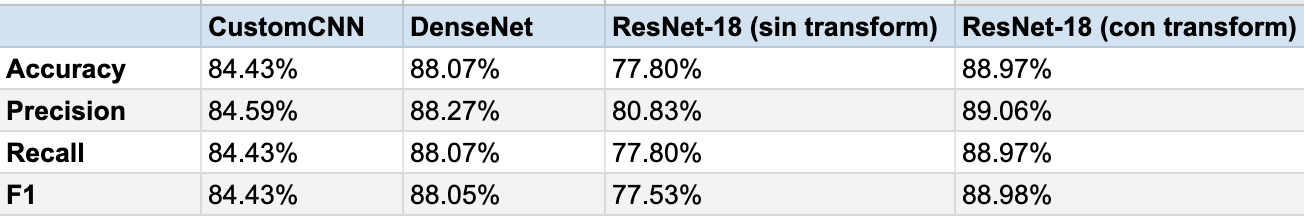

Podemos ver que el modelo con mejores resultados es ResNet-18 con transformaciones. Image Augmentation permitió generar un modelo que generaliza de gran manera, siendo ResNet-18 sin transformaciones el de peores resultados. 